In [1]:
import csv
import json

import numpy
import pandas
from time import time 
import re

from matplotlib import pyplot
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# eğitim ve test verilerini aldık
authored_contents = pandas.read_csv("C:/Users/Selin/Desktop/JupyterProjects/train.csv")
unauthored_contents = pandas.read_csv("C:/Users/Selin/Desktop/JupyterProjects/test.csv")

In [3]:
authored_contents.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
unauthored_contents.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [5]:
authored_contents.shape

(19579, 3)

In [6]:
# eğitim verilerini yazarlara göre gruplandırdık
training_records = len(authored_contents)

author_eap, author_mws, author_hpl = authored_contents.author.value_counts()

In [7]:
# her içeriğin text uzunluğunu bulduk
authored_contents['text_length'] = authored_contents['text'].str.len()

C:\Users\Selin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


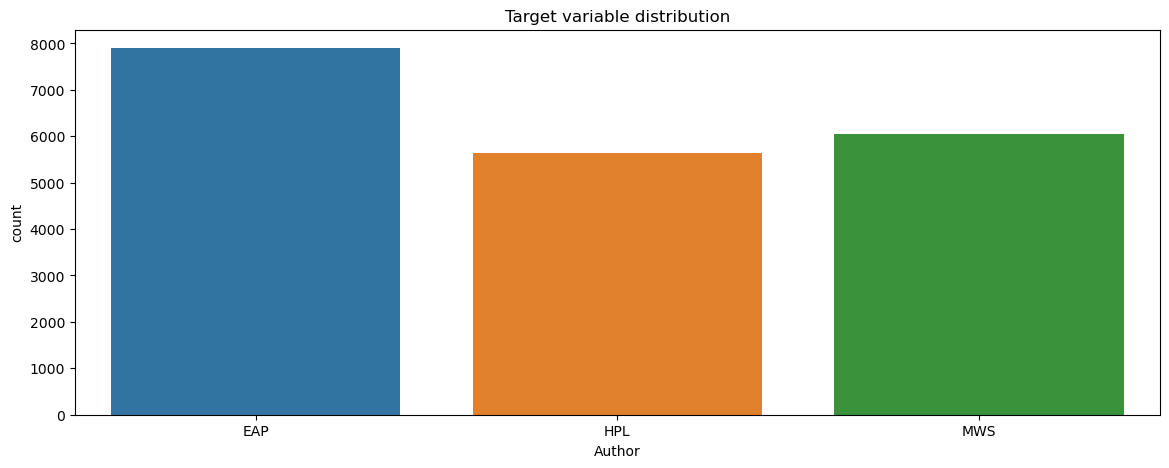

In [8]:
#yazarlara göre veri dağılımını bulduk ve tablo olarak gösterdik(2 üstte toplamları bulmuştuk)
pyplot.figure(figsize=(14,5))
sns.countplot(authored_contents['author'],)
pyplot.xlabel('Author')
pyplot.title('Target variable distribution')
pyplot.show()

In [9]:
#yazarlara göre dokümanları grupladırdık
authored_contents.groupby('author').size() 

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [10]:
# test verilerinin text uzunluğunu bulduk

testing_records = len(unauthored_contents)

unauthored_contents['text_length'] = unauthored_contents['text'].str.len()

In [11]:
# belirli parametreleri kullanarak her yazarın yazım şekillerini inceledik.
def text_len(df):
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: numpy.mean([len(w) for w in str(x).split()]))
    df['num_character_len'] = df['text'].apply(lambda x: len(x))

In [12]:
text_len(authored_contents)
text_len(unauthored_contents)

In [13]:
def plot_heatmap(df):
    pyplot.figure(figsize=(14,6))

    pyplot.subplot(211)
    sns.heatmap(pandas.crosstab(df['author'], df['num_words']), cmap='gist_earth', xticklabels=True)
    pyplot.xlabel('Original text word count')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_uniq_words']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Unique text word count')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_punctuations']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Punctuations')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['mean_word_len']), cmap='gist_heat', xticklabels=False)
    pyplot.xlabel('Mean word length')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()

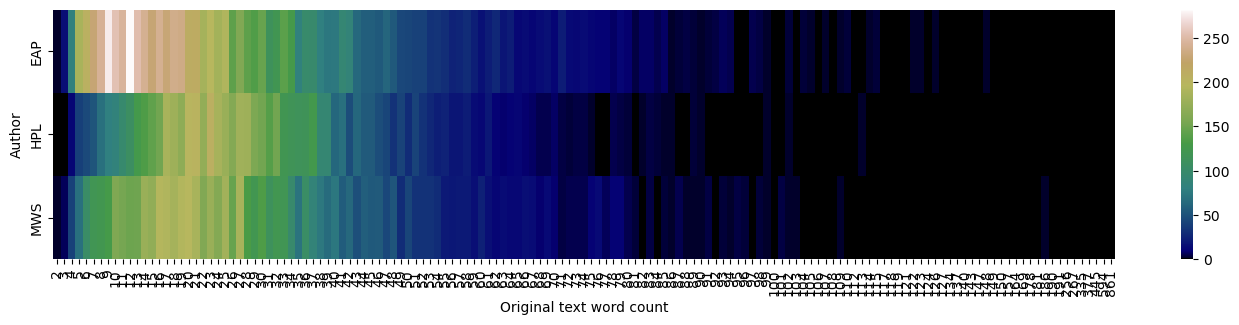

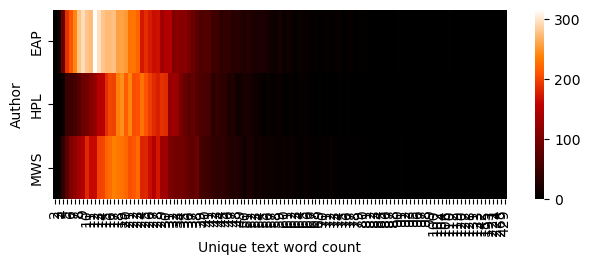

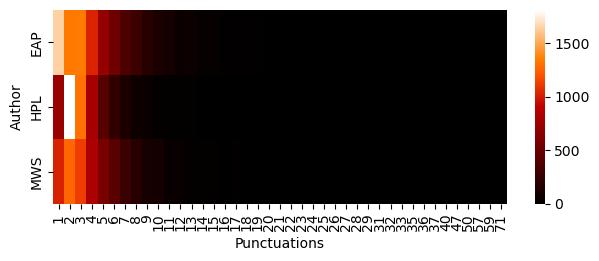

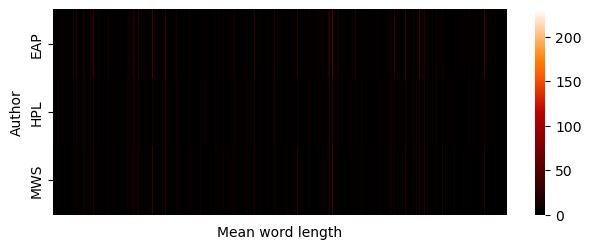

In [14]:
plot_heatmap(authored_contents)


In [15]:
eap_documents = authored_contents[authored_contents.author == 'EAP']['text'].values
hpl_documents = authored_contents[authored_contents.author == 'HPL']['text'].values
mws_documents = authored_contents[authored_contents.author == 'MWS']['text'].values

In [16]:
eap_words = " ".join(eap_documents)
hpl_words = " ".join(hpl_documents)
mws_words = " ".join(mws_documents)

In [17]:
!pip install wordcloud

In [18]:
# her yazara bir sayı atanarak nümerik bir hale getirildi.
authored_contents['numerical_author'] = authored_contents.author.map({ 'EAP': 0, 'HPL': 1, 'MWS': 2 })
authored_contents[['text', 'author', 'numerical_author']].head()

,text,author,numerical_author
0,"This process, however, afforded me no means of...",EAP,0
1,It never once occurred to me that the fumbling...,HPL,1
2,"In his left hand was a gold snuff box, from wh...",EAP,0
3,How lovely is spring As we looked from Windsor...,MWS,2
4,"Finding nothing else, not even gold, the Super...",HPL,1


In [19]:
!pip install nltk

In [20]:
#verinin temizlenmesi

all_stopwords = stopwords.words('english')
ps = PorterStemmer()

def scrub_text(data_frame):
    
    sentences = []
    for i in data_frame.values:

        # sentence = unicode(i[1], 'utf-8')
        sentence = i[1]

        # noktalama işaretlerini kaldırdık.
        sentence = sentence.translate(string.punctuation)
        
        # cümleyi kelimelere ayırdık.
        array_of_words = word_tokenize(sentence)
        
        #Linkleri kaldırdık
        sentence = re.sub(r'@\S+','',sentence)
        sentence = re.sub(r'http\S+','',sentence)
        sentence = re.sub(r'https\S+','',sentence)
        sentence = re.sub(r'pic.\S+','',sentence)
        
        # etkisiz kelimeleri yani ingilizcdeki and, is, a gibi kelimeleri kaldırdık.
        array_of_words = [word for word in array_of_words if word.lower() not in all_stopwords]

        # array_of_words dizisinin içinde aynı olan kelimeleri tek hale getirdik.
        array_of_words = [ps.stem(word) for word in array_of_words]
        cleaned_sentence = ' '.join(array_of_words)

        sentences.append(cleaned_sentence)

    return sentences

In [21]:
# Eğitim ve test verileri üzerinde temizleme işlemini yaptık.

training_cleaned_texts = scrub_text(authored_contents)
testing_cleaned_texts = scrub_text(unauthored_contents)

In [22]:
authored_contents['scrubbed_text'] = training_cleaned_texts

unauthored_contents['scrubbed_text'] = testing_cleaned_texts

In [23]:
X = authored_contents['scrubbed_text']
Y = authored_contents['numerical_author']

In [24]:
!pip install sklearn

In [25]:
import sklearn

In [26]:
#burda test ve eğitim verilerini ayırdık %20 %80
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 0)

In [27]:
# ayrımı gösterdik.

# Features features selection daha yapılmadı burda toplam veriden bahsediyoruz.
print("Training set has " + str(X_train.shape[0]) + " features.")
print("Testing set has " + str(X_test.shape[0]) + " features.")

# Labels
print("Training set has " + str(Y_train.shape[0]) + " labels.")
print("Testing set has " + str(Y_test.shape[0]) + " labels.")

print("\nPrinting labels set...")
print(Y_train.value_counts())

print(Y_test.value_counts())

Training set has 15663 features.
Testing set has 3916 features.
Training set has 15663 labels.
Testing set has 3916 labels.

Printing labels set...
0    6300
2    4830
1    4533
Name: numerical_author, dtype: int64
0    1600
2    1214
1    1102
Name: numerical_author, dtype: int64


In [28]:
#çapraz doğrulama burda train'in de bir kısmı öğrenirken diğer kısmı doğrulama yapıyor.
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X,Y,stratify = Y,test_size = 0.2,random_state = 42, shuffle = True)

In [29]:
#eğitim setinde feature selection yapıldı.
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X2_train)

#giriş verilerini vektörize ettik. algoritmalarda bu yapıyı kullanacağız.
training_vectorizer = vectorizer.transform(X2_train)

In [30]:
#vektor uzunluğu bulundu
print(len(vectorizer.get_feature_names_out())) 
#X2_test içinde feature selection yapıldı
testing_vectorizer = vectorizer.transform(X2_test)

14280


In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [32]:
#Multinomial Naive Bayes

kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)
model = MultinomialNB()
start = time()
#result ta parametreler sırasıyla kullanılan algo. vektörize edilmiş girdi verisi
#sonucu karşılaştırmak için kullanılacak veriler
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

NBmvalue = str(results.mean())
NBttime = str((end - start))
print("Mean value: " + NBmvalue)
print("Training time: " + NBttime)

Mean value: 0.8227032481065006
Training time: 0.0508267879486084


In [33]:
#SVM
from sklearn.svm import SVC

kfold = KFold(n_splits = 10, random_state = 7,shuffle = True)

model = SVC()
start = time()
#result ta parametreler sırasıyla kullanılan algo. vektörize edilmiş girdi verisi
#sonucu karşılaştırmak için kullanılacak veriler
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()
SVMmvalue = str(results.mean())
SVMttime = str(end - start)
print("Mean value: " + SVMmvalue)
print("Training time: " + SVMttime)

Mean value: 0.7680529372979256
Training time: 254.48486018180847


In [34]:
#Stochastic Gradient Descent Classifier

from sklearn.linear_model import SGDClassifier

kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)

model = SGDClassifier()
start = time()
#result ta parametreler sırasıyla kullanılan algo. vektörize edilmiş girdi verisi
#sonucu karşılaştırmak için kullanılacak veriler
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()
SGDCmvalue =  str(results.mean())
SGDCttime = str(end - start)
print("Mean value: " + SGDCmvalue)
print("Training time: " + SGDCttime)

Mean value: 0.7935888345269327
Training time: 0.78312087059021


In [35]:
!pip install xgboost

In [36]:
# XGBoost

from xgboost import XGBClassifier

model = XGBClassifier()
start = time()
#result ta parametreler sırasıyla kullanılan algo. vektörize edilmiş girdi verisi
#sonucu karşılaştırmak için kullanılacak veriler
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()
Xmvalue = str(results.mean())
Xttime = str(end - start)
print("Mean value: " + Xmvalue)
print("Training time: " + Xttime)


Mean value: 0.7096985967769147
Training time: 7.939887285232544


In [38]:
#sonuçları bir tablo olarak görmek için:
data = numpy.array([[NBmvalue, NBttime], [SVMmvalue, SVMttime], [SGDCmvalue, SGDCttime], [Xmvalue, Xttime]])
row_name = ['Multinomial Naive Bayes', 'SVM', 'SGDC','XGBoost']
column_name = ['Mean Accuracy', 'Training Time']
dataset = pandas.DataFrame(data=data,index = row_name ,columns=column_name)
print(dataset)

                              Mean Accuracy       Training Time
Multinomial Naive Bayes  0.8227032481065006  0.0508267879486084
SVM                      0.7680529372979256  254.48486018180847
SGDC                     0.7935888345269327    0.78312087059021
XGBoost                  0.7096985967769147   7.939887285232544
